In [2]:
import numpy as np
import pandas as pd

# K-Means Algorithm

K-Means algorithm is a clustring algorithm. It is also a classic Expectation-Maximization algorithm.<br> 
Given a set of observations (x1, x2, ..., xn), where each observation is a d-dimensional real vector, k-means clustering aims to partition the n observations into k (≤ n) sets S = {S1, S2, ..., Sk} so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance) <br>
The Step is as follows:
1. Randomly select k "cluster centers" from the data set;<br>
2. For each iteration (iterate through all points):<br>
(1). Find the nearest center for each point, and store the cluster for each center; <br>
(2). Calculate the new center for each cluster; <br>
(3). If there are no change of the means, end the loop; otherwise iterate. <br>

In [3]:
class KMeans():
    def __init__(self, k = 3, num_iter = 1000):
        self.model_name = 'KMeans'
        self.k = k
        self.num_iter = num_iter
        self.centers = None
        self.RM = None
        
        self.centroids = None
        self.closest_centroid = None
        
    def train(self, X):
        np.random.seed(42)
        initial_centroid_indices = np.random.choice(X.shape[0], size=self.k, replace=False)
        self.centroids = X[initial_centroid_indices]
        
        for _ in range(self.num_iter):
            distance_vectors = (self.centroids.reshape(self.k, 1, -1) - X)
            distances_to_centroids = np.linalg.norm(distance_vectors, axis=2)
            self.closest_centroid = np.argmin(distances_to_centroids, axis=0) 
            
            new_centroids = np.array([X[self.closest_centroid == centroid_index].mean(axis=0) for centroid_index in range(self.k)])
            
            if np.all(new_centroids == self.centroids):
                break
            else:
                self.centroids = new_centroids
        
        # using an identity matrix to one hot encode
        self.RM = np.eye(self.k)[self.closest_centroid]
        
        return self # not sure why the the api wants it to be this way

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
Y = iris.target

In [5]:
X = X[:,2:4]
X.shape

(150, 2)

In [6]:
clf = KMeans(k = 3)
model = clf.train(X)

In [7]:
model.RM.shape

(150, 3)

(150,) (150, 2)
(150,) (150, 2)
(150,) (150, 2)
(54, 2)
(50, 2)
(46, 2)


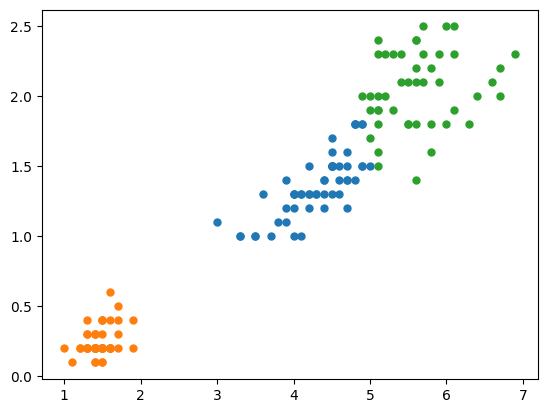

In [10]:
r, c = model.RM.shape
groups = []
for i in range(c):
    index = model.RM[:,i] == 1
    print(index.shape, X.shape)
    groups.append(X[index])
fig, ax = plt.subplots()
ax.margins(0.05)
for group in groups:
    print(group.shape)
    ax.plot(group[:,0], group[:,1], marker='o', linestyle='', ms=5)

In [11]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
X = X[:,[0,2]]

(58, 2)
(51, 2)
(41, 2)


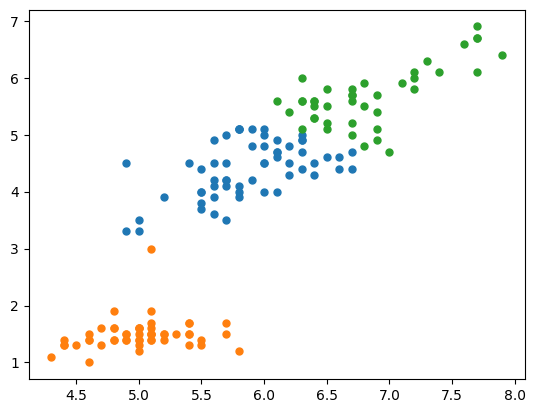

In [12]:
clf = KMeans(k = 3)
model = clf.train(X)
r, c = model.RM.shape
groups = []
for i in range(c):
    index = model.RM[:,i] == 1
    groups.append(X[index])
fig, ax = plt.subplots()
ax.margins(0.05)
for group in groups:
    print(group.shape)
    ax.plot(group[:,0], group[:,1], marker='o', linestyle='', ms=5)

## 3 dimension

In [14]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
X = X[:,1:4]

In [15]:
clf = KMeans(k = 3)
model = clf.train(X)
# model = clf.fit(X)

In [16]:
from mpl_toolkits.mplot3d import Axes3D

In [17]:
groups = []
r, c = model.RM.shape
for i in range(c):
    index = model.RM[:,i] == 1
    groups.append(X[index])

Note: We should expect different results every time we run Kmeans as the centers are randomly initialized.

# Gaussian Mixture

Gaussian Mixture Algorithm is a softer version of the k-means algorithm. It is also a classic example of the Expectation-Maximization Algorithm. <br>
In Gaussian Mixture Algorithm, we model the data as coming from a mixture of Gaussians.<br>
In this example, we will be using a randomly generated Gaussian Distribution. <br>

In [20]:
import numpy as np

def gaussian(X, mu, cov):
    """ 
        Fucntion to create mixtures using the Given matrix X, given covariance and given mu

        Return:
        transformed x.
    """
    # X should be matirx-like
    n = X.shape[1]
    diff = (X - mu).T
    
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)
    

In [21]:
from sklearn.datasets import make_blobs

In [22]:
X, y = make_blobs(n_samples=500, n_features=3, cluster_std=2, random_state=42)
X.shape, y.shape

((500, 3), (500,))

In [23]:
fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig, elev = -150, azim = 130)
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o')

<Figure size 600x600 with 0 Axes>

In [24]:
# initialize clusters with kmeans
# initial distributions can start off with assumed equal probability along with unit covariance matrix
def initialize_clusters(X, n_clusters):
    """ 
        Initialize the clusters by storing the information in the data matrix X into the clusters

        Parameter:
            X: Input feature matrix
            n_clusters: Number of clusters we are trying to classify

        Return:
            cluster: List of clusters. Each cluster center is calculated by the KMeans algorithm above.
    """
    clusters = []
    index = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().train(X)
    mu_k = kmeans.centroids
    
    for i in range(n_clusters):
        clusters.append({
            'w_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [31]:
def expectation_step(X, clusters):
    """ 
        "E-Step" for the GM algorithm

        Parameter:
            X: Input feature matrix
            clusters: List of clusters
    """
    
    numerators = []
    for cluster in clusters:
        w_k = cluster['w_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        numerator = w_k * gaussian(X, mu_k, cov_k)
        numerators.append(numerator)
    numerators = np.array(numerators)
    
    # for each datapoint you want to consider all the situations that can lead to it. considering each cluster. and then normalizing by it. 
    denominators = numerators.sum(axis=0, keepdims=True)
    
    # posterior for every datapoint. getting the probability of a cluster for each datapoint
    posteriors = numerators / denominators
    
    return posteriors
    # return posteriors.shape

In [32]:
def maximization_step(X, clusters, posteriors):
    """ 
        "M-Step" for the GM algorithm

        Parameter:
            X: Input feature matrix
            clusters: List of clusters
    """
    N = float(X.shape[0])
  
    for j, cluster in enumerate(clusters):
        
        posterior = posteriors[j]
        w_k = np.sum(posterior) / X.shape[0]
        mu_k = np.sum(posterior * X, axis=0) / np.sum(posterior)
        
        diffs = X - mu_k
        diffsr = diffs.reshape(diffs.shape[0], -1, 1)
        covs = np.einsum('ijk,ilk->ijl', diffsr, diffsr)
        cov_k = np.sum(posterior.reshape(-1, 1, 1) * covs, axis=0) / np.sum(posterior)
        
        cluster['w_k'] = w_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [33]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [34]:
clusters = initialize_clusters(X, 3)
posteriors = expectation_step(X, clusters)
maximization_step(X, clusters, posteriors)

In [35]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    print(clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))

    for i in range(n_epochs):
        
        posteriors = expectation_step(X, clusters)
        maximization_step(X, clusters, posteriors)

        # likelihood, sample_likelihoods = get_likelihood(X, clusters)
        # likelihoods[i] = likelihood
        likelihood, sample_likelihoods = None, None
        # likelihoods[i] = likelihood
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['w_k']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods

In [39]:
clusters, likelihoods, scores, sample_likelihoods = train_gmm(X, 3, 1000)

[{'w_k': 0.3333333333333333, 'mu_k': array([-9.14236283,  7.36019548,  2.18520097]), 'cov_k': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])}, {'w_k': 0.3333333333333333, 'mu_k': array([ 1.8610968 , -6.94733839, -6.8452782 ]), 'cov_k': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])}, {'w_k': 0.3333333333333333, 'mu_k': array([-2.56532321,  9.27348125,  4.89537514]), 'cov_k': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])}]


In [40]:
clusters

[{'w_k': 0.32628619057363845,
  'mu_k': array([-9.12188805,  7.32642416,  2.19555697]),
  'cov_k': array([[ 4.32271676, -0.93428945, -0.05139593],
         [-0.93428945,  3.92968013, -0.56383042],
         [-0.05139593, -0.56383042,  3.41186883]])},
 {'w_k': 0.3339999999998166,
  'mu_k': array([ 1.8610968 , -6.94733839, -6.8452782 ]),
  'cov_k': array([[ 3.26150799,  0.03435451,  0.06688666],
         [ 0.03435451,  4.3922024 , -0.43076908],
         [ 0.06688666, -0.43076908,  4.30326999]])},
 {'w_k': 0.3397138094265449,
  'mu_k': array([-2.65689002,  9.28500135,  4.85580038]),
  'cov_k': array([[ 4.14983314,  0.11413873, -0.04662883],
         [ 0.11413873,  3.83310137,  0.4905652 ],
         [-0.04662883,  0.4905652 ,  4.33351196]])}]

In [41]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
# print('Scores by sklearn:\n', gmm_scores[0:20])
# print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[-9.11359686  7.33283087  2.19630664]
 [ 1.8610968  -6.94733839 -6.8452782 ]
 [-2.64468499  9.28493405  4.86339568]]
Means by our implementation:
 [[-9.12188805  7.32642416  2.19555697]
 [ 1.8610968  -6.94733839 -6.8452782 ]
 [-2.65689002  9.28500135  4.85580038]]


In [93]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[ 4.39074551  1.20199258  6.3022327 ]
 [ 8.98839935  9.51954291  1.05759375]
 [ 5.35315547 -2.23816274 -2.56267013]]
Means by our implementation:
 [[ 5.35182907 -2.2367173  -2.55786065]
 [ 8.9887496   9.52143291  1.05640879]
 [ 4.39280888  1.20571767  6.30498601]]
Scores by sklearn:
 [-6.13726675 -7.51911416 -6.89281068 -9.43670026 -8.6028534  -7.3616024
 -6.53936695 -7.22989094 -6.20257524 -6.23528246 -9.16562507 -8.4825674
 -9.5302818  -7.32150604 -7.52215321 -7.45975524 -7.10790769 -6.08008756
 -7.17619947 -8.18014084]
Scores by our implementation:
 [-6.13743663 -7.51459162 -6.89631166 -9.43752363 -8.60238419 -7.36121834
 -6.53810162 -7.22983957 -6.20161164 -6.23643104 -9.17158307 -8.47802193
 -9.53262406 -7.32109316 -7.52071805 -7.4624631  -7.1077944  -6.07923737
 -7.17524634 -8.18078416]
